# W207 Final Project: Facial Recognition

### Team: MapReduce, MapReuse, MapRecycle
Members: Tennison Yu, Madeleine Bulkow, Mark Paluta, Alex Dauenhauer

https://github.com/tyu0912/207_facial_recognition/tree/master
https://github.com/tyu0912/MIDS_W207_facial_recognition/issues

# Overall Thoughts/Actions

This is the final project submission from Team MapReduce,MapReuse,MapRecycle for W207: Applied Machine Learning as part of the MIDS program at UC Berkeley. We are working with data from https://www.kaggle.com/c/facial-keypoints-detection/data and the goal is to accurately identify facial features on an (x, y) coordinate system based on an input image. 


*Ideas to try*
- Use other features to predict one specific feature
- Break out the image into its own matrix where each pixel is a feature and then predict each facial characteristic position
    - First use subset of images that contain all key points and then just predict the locations. 

*Knockout List/Plan*
- Prepare a summary table of quality metrics: L2 distance, L1 distance
- use graphviz feature to visualize the model - ALEX
- How does samples size / filter number / number of layers affect performance?

*Things to think about*
- separate augmented data sets as well as full data set of all augmentations
- Possible DOE for toggling features

*Naming/Working Rules*
- train_data, train_labels
- dev_data, dev_labels
- Feature Engineering: put "_transformation done". Ex: train_data_blur

*Useful Items*
- Learn Keras
- https://www.kaggle.com/c/facial-keypoints-detection#getting-started-with-r
- http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#k-NN_regression
- http://www.eurecom.fr/en/publication/4768/download/mm-publi-4768.pdf
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

*Tennison Merge Notes*
- Need to make the output part of the algorithm
- The simple algorithm part needs to be fleshed out. Hyperparameter tuning?
- More transformations perhaps?
- Do we still want to do the simple neural net?
- Do we still want to play around with having more graphs to show training time, etc. 

## Overall Project Flow

DEADLINE --> Wednesday

- Reorg - Alex
- Step 1 - Research question/Intro
    - how can we accurately predict pixel locations of facial keypoints?
    - map out high level plan of attack
- Step 2 - EDA
    - Explore data - all
    - examining edge cases - Mark
    - Make decisions on NA values, data to keep - Mark
        - to think about --> possibly doing augmentations on portions on the dataset for development
    - Explanation of why we are using a custom loss function rather than filling NA values with some guess at the feature location - all
- Step 3 - Feature engineering/augmentation --> 3-4 augmentations maximum
    - Prepocess
        - gaussian blur --> yes - Tennison
    - Augmentation
        - Flip images --> yes - Alex
        - darken and lighten (either this or normalize) - Tennison
        - rotate --> maybe - Tennison/Maddie
        - Zooming/cropping --> maybe
    - try to correct errors from simple models
- Step 4 - Define success
    - train on simple models for baseline comparison
        - 'DecisionTree': DecisionTreeRegressor(), # Maddie
        - 'NearestNeighbors': KNeighborsRegressor(), # Tennison
        - 'NaiveBayes': NaiveBayes(), # Mark
        - 'LogisticRegression': LogisticRegression() # Alex
        - why did we choose these simple models? - all
            - Everyone choose their own model, not linear regression
            - motivation section
            - run the model
            - why didn't it work?
        - examine how models are handling missing values
        - try augmentations on each model
    - look at error (RMS, absolute, others?) as well as training time
- Step 5 - Examine errors on simple models - all
    - Determine why errors are occurring
- Step 6 - build models
    - train a CNN model on each augmentation
    - Need to explain model hyperparameter choices - Alex/All
        - number of layers
        - number of filters
        - optimizer
        - activation --> 'relu' industry standard
- Step 7 - predict / measure success - all
    - Summary table of performance
    - predict on test data
    - get Kaggle score
    - defeat Trump
- step 8 - site sources - all

# Introduction

placeholder

# Import Packages, Load data

In [1]:
# Optional cell to install/update all required packages
! pip install keras tensorflow numpy pandas matplotlib scipy imgaug opencv-python > nul
print('Packages installed, output supressed for cleanliness')

Packages installed, output supressed for cleanliness


In [2]:
import time, os, keras, tensorflow as tf, warnings, imgaug as ia
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pydot
from sklearn.utils import shuffle
from keras import backend as K
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, mean_squared_error
# from sklearn.model_selection import GridSearchCV
from scipy import stats
from imgaug import augmenters as iaa

# set tensorflow as keras backend
if K.backend() != "tensorflow":
    os.environ['KERAS_BACKEND'] = "tensorflow"
    reload(K)

print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

# Initiate settings and load the data.
np.random.seed(0)
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
# features = train.columns[:-1]

C:\Users\alexd\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.0
numpy version: 1.14.3


# EDA

In [3]:
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
print (images.shape)

(16, 128, 128, 3)


## Glancing at the Data

In [4]:
print('Sample Training Labels')
train[train.columns[:-1]].head(5)

Sample Training Labels


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [5]:
print('Sample Image Pixels')
train['Image'].head(5)

Sample Image Pixels


0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

In [6]:
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

**Observations:**  
- Many labels have a lot of missing data
- The only label that is complete is the nose tip
- Images are currently strings with each pixel value separated by a space
- Need to process the data to separate images from labels and convert image format to numpy arrays

## Reformat data

- for keras model we need numpy array of shape = (batch, image_width, image_height, num_channels)
- Images in dataset are 96x96 grayscale images, therefore shape should be (X, 96, 96, 1)
- We will split the training set into 80% train data and 20% dev data in the loading function

In [7]:
def process_datasets(df, test=False, fillna=False, dropna=False):
    '''This function reformats the data from a dataframe to a numpy
    array of the appropriate shape.
    '''

    # whether or not to remove images with missing labels
    if dropna:
        df = df.dropna()
    
    # build feature dict for reference in future functions
    feature_dict = {label:i for i,label in enumerate(df.columns[:-1].values)}
    
    # separate images into numpy arrays
    images_pixel_feature = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # rescale pixel values to [0,1] interval and reshape
    images_pixel_feature = np.stack(images_pixel_feature) / 255
    images_pixel_feature = images_pixel_feature.reshape(-1, 96, 96, 1)
    
    
    # separate the labels and scale them to [-1,1] interval for use of 
    # rectified linear unit activation
    if not test:
        facial_point_labels = df.iloc[:, :-1]
        if fillna:
            facial_point_labels.fillna(np.mean(facial_point_labels, axis=0), inplace=True)
        facial_point_labels = facial_point_labels.values
        facial_point_labels = (facial_point_labels - 48) / 48
    else:
        facial_point_labels = None
    
    return images_pixel_feature, facial_point_labels, feature_dict

Raw data

In [8]:
train_data_raw, train_labels_raw, feature_dict = process_datasets(train)
test_data, test_labels, _ = process_datasets(test, test=True)

dropping NAs

In [9]:
train_data_complete, train_labels_complete, _ = process_datasets(
    train, dropna=True
)

In [10]:
feature_dict

{'left_eye_center_x': 0,
 'left_eye_center_y': 1,
 'right_eye_center_x': 2,
 'right_eye_center_y': 3,
 'left_eye_inner_corner_x': 4,
 'left_eye_inner_corner_y': 5,
 'left_eye_outer_corner_x': 6,
 'left_eye_outer_corner_y': 7,
 'right_eye_inner_corner_x': 8,
 'right_eye_inner_corner_y': 9,
 'right_eye_outer_corner_x': 10,
 'right_eye_outer_corner_y': 11,
 'left_eyebrow_inner_end_x': 12,
 'left_eyebrow_inner_end_y': 13,
 'left_eyebrow_outer_end_x': 14,
 'left_eyebrow_outer_end_y': 15,
 'right_eyebrow_inner_end_x': 16,
 'right_eyebrow_inner_end_y': 17,
 'right_eyebrow_outer_end_x': 18,
 'right_eyebrow_outer_end_y': 19,
 'nose_tip_x': 20,
 'nose_tip_y': 21,
 'mouth_left_corner_x': 22,
 'mouth_left_corner_y': 23,
 'mouth_right_corner_x': 24,
 'mouth_right_corner_y': 25,
 'mouth_center_top_lip_x': 26,
 'mouth_center_top_lip_y': 27,
 'mouth_center_bottom_lip_x': 28,
 'mouth_center_bottom_lip_y': 29}

In [11]:
### DON'T RUN THIS CELL MORE THAN ONCE WITHOUT RE-RUNNING PROCESS DATASETS! ###

# 20% of the data will go to dev
percent_to_dev = 0.2 

train_data_orig, dev_data_orig, train_labels_orig, dev_labels_orig = train_test_split(
    train_data_raw, train_labels_raw, test_size=percent_to_dev
)
train_data_complete, dev_data_complete, train_labels_complete, dev_labels_complete = train_test_split(
    train_data_complete, train_labels_complete, test_size=percent_to_dev
)

print("\nTrain data shape", train_data_orig.shape)
print("Dev data shape", dev_data_orig.shape)
print("Train labels shape", train_labels_orig.shape)
print("Dev labels shape", dev_labels_orig.shape)
print("\nTrain data no-missing-values shape", train_data_complete.shape)
print("Dev data no-missing-values shape", dev_data_complete.shape)
print("Train labels no-missing-values shape", train_labels_complete.shape)
print("Dev labels no-missing-values shape", dev_labels_complete.shape)

print("\nData Generation Finished")


Train data shape (5639, 96, 96, 1)
Dev data shape (1410, 96, 96, 1)
Train labels shape (5639, 30)
Dev labels shape (1410, 30)

Train data no-missing-values shape (1712, 96, 96, 1)
Dev data no-missing-values shape (428, 96, 96, 1)
Train labels no-missing-values shape (1712, 30)
Dev labels no-missing-values shape (428, 30)

Data Generation Finished


## Examine Random Sample

In [12]:
def plot_sample(data, labels, labels2=None):
    '''
    data must be a numpy.ndarray of shape (X, 96, 96, 1)
    labels must be a numpy.ndarray (X, 30)
    X must be any square number
    '''
    
    dim = np.sqrt(len(data))
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(len(labels)):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, labels[i][1::2] * 48 + 48, c='r')
        if not labels2 is None:
            ax.scatter(labels2[i][0::2] * 48 + 48, labels2[i][1::2] * 48 + 48, c='b')

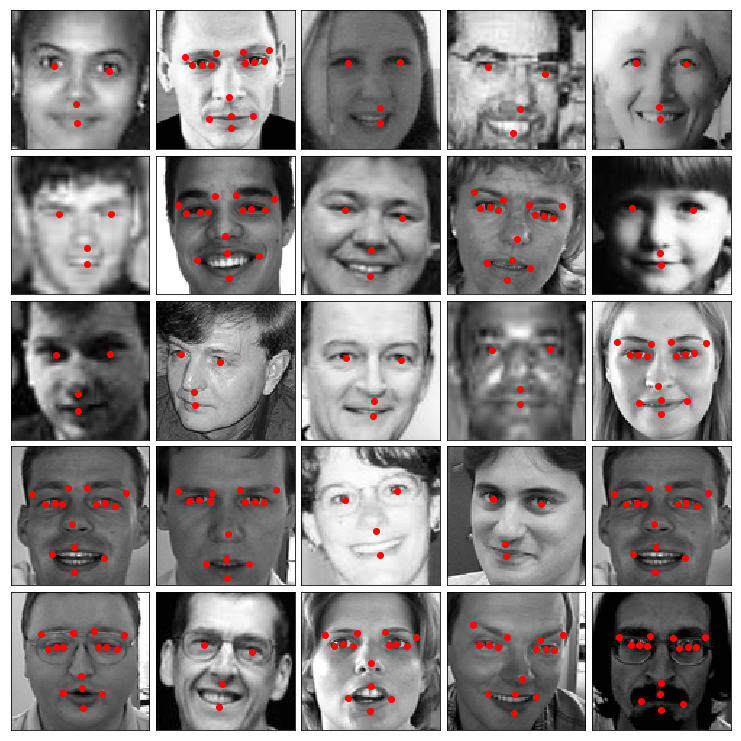

In [13]:
# Output sample of random images. Some of these will be the NA data
n = 25
idx = np.random.randint(0, len(train_data_raw), n)
data_sample = train_data_raw[idx, :, :, :]
label_sample = train_labels_raw[idx, :]
plot_sample(data_sample, label_sample)

## Examine Edge Cases

In [14]:
# In addition to random faces, let's check out some edge cases

edge_cases = []

# additional interesting cases to explore if time allows:
# - multiple faces in one image
# - upside down faces
# - incomplete faces (not all key points present)
# - race/lighting (average shade of pixels in facial region, plot couple darkest/lightest)
# - faces halfway offscreen/covered (could try one eye present, one not), image 154 has eyes and nose but mouth offscreen
# - additonal edge cases discovered incidentally 
#    - sunglasses (1802)

#  - eventually will want to manually remove 2153, 4971 is questionable depending on which points those are

# compile interesting cases
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_x']].argsort()[:10])           # noses near left of screen
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_x']].argsort()[-10:])          # noses near right of screen
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_y']].argsort()[:10])           # noses near top of screen
edge_cases.extend((train_labels_raw[:,feature_dict['right_eye_center_x']] -
                   train_labels_raw[:,feature_dict['left_eye_center_x']]).argsort()[:10])  # wide faces
edge_cases.extend((train_labels_raw[:,feature_dict['right_eye_center_x']] -
                   train_labels_raw[:,feature_dict['left_eye_center_x']]).argsort()[-9:]) # small faces
# edge_cases.extend((train_labels[:,feature_dict['right_eye_center_x']] -
#                    train_labels[:,feature_dict['left_eye_center_x']]).argsort()[-7:]) # small faces

print(len(edge_cases), edge_cases)

data_edge = train_data_raw[edge_cases, :, :, :]
label_edge = train_labels_raw[edge_cases, :]

49 [1907, 6315, 1652, 1620, 6271, 2845, 2191, 1966, 1861, 5795, 2590, 2453, 1877, 3188, 2075, 6834, 2199, 6493, 2175, 4263, 3510, 6765, 5117, 6782, 3647, 4786, 2036, 466, 329, 503, 1747, 2289, 6859, 2572, 2776, 3152, 5167, 6585, 3556, 4445, 2137, 2175, 2090, 1687, 1866, 1834, 1938, 2239, 1620]


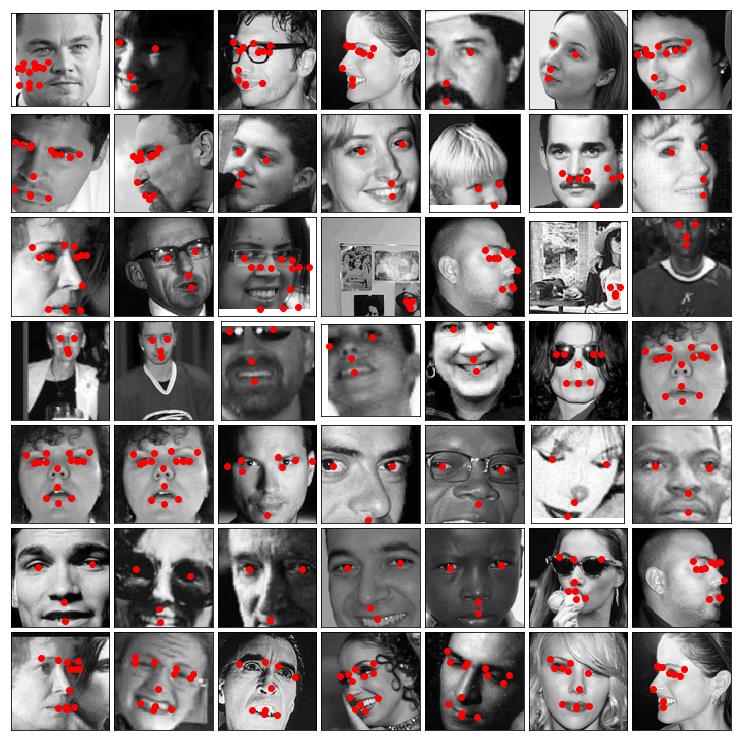

In [15]:
plot_sample(data_edge, label_edge)

**Observations:**  
- Need to examine code, looks like duplicate images are being grabbed. Could be real if one image is in the top category for multiple edge case types
- Some images have features obscured (hair over eyes, sunglasses, etc) and therefore are missing labels
- Some cases look like purely bad data that may need to be removed

# Data Augmentation/Preprocessing

## Mirror images

In [16]:
def mirror_data(data, labels, features):
    '''This function flips the images and labels to their new columns
    Input data is numpy array of shape (X, 96, 96, 1)
    Input labels is numpy array of shape (X, 30)
    features is a list of column header strings
    '''
    
    # flip the images
    data_flipped = data[:, :, ::-1, :]
    
    # flip the labels
    labels_flipped = np.zeros(labels.shape)
    for idx in range(len(labels)):
        for i,s1 in enumerate(features):
            parts = s1.partition('_')
            if parts[0] == 'left' or parts[0] == 'right':
                coord = parts[-1]
            elif parts[0] == 'mouth':
                parts = s1.split('_', maxsplit=2)
                if 'corner' in parts[-1]:
                    coord = parts[-1]        
                elif 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            else:
                if 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            for j in range(i+1,len(features)-1):
                s2 = features[j]
                if coord in s2:
                    if 'x' in coord:
                        labels_flipped[idx,i] = labels[idx,j] * -1
                        labels_flipped[idx,j] = labels[idx,i] * -1
                    else:
                        labels_flipped[idx,i] = labels[idx,j]
                        labels_flipped[idx,j] = labels[idx,i]
                
    return data_flipped, labels_flipped

## Generalized Augmentations

In [17]:
def augment_images(data, labels, aug):
    
    data = data * 255
    aug_labels =[]
    seq_det = aug.to_deterministic()
    aug_data = seq_det.augment_images(data)
    
    keypoints_on_images = []
    
    for features in labels:
        keypoints = []
        
        for c in range(0, features.shape[0], 2):
            x = features[c]* 48 + 48
            y = features[c+1]* 48 + 48

            keypoints.append(ia.Keypoint(x=x, y=y))

        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=(96,96)))
    
    keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)    
        
    for keypoints_after in keypoints_aug:
        aug_labels_set = []
        
        for i, keypoint in enumerate(keypoints_after.keypoints):
            aug_labels_set.append((keypoint.x - 48) / 48)
            aug_labels_set.append((keypoint.y - 48) / 48)
                
        aug_labels.append(aug_labels_set)
        
    return aug_data/255, np.array(aug_labels)

In [18]:
# contrast the brightness of training and dev data
aug = iaa.OneOf([iaa.Multiply((2,2)),iaa.Add((-125,-75))])

contrast_data, contrast_labels = augment_images(train_data_orig, train_labels_orig, aug)
contrast_dev_data, contrast_dev_labels = augment_images(dev_data_orig, dev_labels_orig, aug)
contrast_data_complete, contrast_labels_complete = augment_images(train_data_complete, train_labels_complete, aug)
contrast_dev_data_complete, contrast_dev_labels_complete = augment_images(dev_data_complete, dev_labels_complete, aug)


# gaussian blur training and dev data
aug = iaa.Sequential([iaa.GaussianBlur(sigma=1)])

blur_data, blur_labels = augment_images(train_data_orig, train_labels_orig, aug)
blur_dev_data, blur_dev_labels = augment_images(dev_data_orig, dev_labels_orig, aug)
blur_data_complete, blur_labels_complete = augment_images(train_data_complete, train_labels_complete, aug)
blur_dev_data_complete, blur_dev_labels_complete = augment_images(dev_data_complete, dev_labels_complete, aug)

# rotate training and dev data
aug = iaa.Sequential([iaa.Affine(rotate=(-10,10))])

rotate_data, rotate_labels = augment_images(train_data_orig, train_labels_orig, aug)
rotate_dev_data, rotate_dev_labels = augment_images(dev_data_orig, dev_labels_orig, aug)
rotate_data_complete, rotate_labels_complete = augment_images(train_data_complete, train_labels_complete, aug)
rotate_dev_data_complete, rotate_dev_labels_complete = augment_images(dev_data_complete, dev_labels_complete, aug)

# mirror training and dev data
flipped_data, flipped_labels = mirror_data(
    train_data_orig, train_labels_orig, list(feature_dict.keys())
)
flipped_dev_data, flipped_dev_labels = mirror_data(
    dev_data_orig, dev_labels_orig, list(feature_dict.keys())
)
flipped_data_complete, flipped_labels_complete = mirror_data(
    train_data_complete, train_labels_complete, list(feature_dict.keys())
)
flipped_dev_data_complete, flipped_dev_labels_complete = mirror_data(
    dev_data_complete, dev_labels_complete, list(feature_dict.keys())
)

## Concatenate datasets

In [19]:
# # original data, no missing values (for training the sklearn baseline models)
# train_data_complete = train_data_complete
# train_labels_complete = train_labels_complete
# dev_data_complete = dev_data_complete
# dev_labels_complete = dev_labels_complete

# # original data with missing values (for first pass of CNN)
# train_data_orig = train_data
# train_labels_orig = train_labels
# dev_data_orig = dev_data
# dev_labels_orig = dev_labels

# augmented data with missing values (for second pass of CNN)
train_data_aug = np.concatenate(
    (train_data_orig,
     flipped_data, 
     contrast_data, 
     blur_data, 
     rotate_data), 
    axis=0
)
train_labels_aug =  np.concatenate(
    (train_labels_orig, 
     flipped_labels, 
     contrast_labels, 
     blur_labels, 
     rotate_labels), 
    axis=0
)
dev_data_aug = np.concatenate(
    (dev_data_orig,
     flipped_dev_data, 
     contrast_dev_data, 
     blur_dev_data, 
     rotate_dev_data), 
    axis=0
)
dev_labels_aug = np.concatenate(
    (dev_labels_orig, 
     flipped_dev_labels, 
     contrast_dev_labels, 
     blur_dev_labels, 
     rotate_dev_labels), 
    axis=0
)

# augmented data, no missing values (for prediction with 2-layer NN)
train_data_aug_comp = np.concatenate(
    (train_data_complete, 
     flipped_data_complete, 
     contrast_data_complete, 
     blur_data_complete, 
     rotate_data_complete), 
    axis=0
)
train_labels_aug_comp = np.concatenate(
    (train_labels_complete,
     flipped_labels_complete, 
     contrast_labels_complete, 
     blur_labels_complete, 
     rotate_labels_complete), 
    axis=0
)
dev_data_aug_comp = np.concatenate(
    (dev_data_complete,
     flipped_dev_data_complete, 
     contrast_dev_data_complete, 
     blur_dev_data_complete, 
     rotate_dev_data_complete), 
    axis=0
)
dev_labels_aug_comp = np.concatenate(
    (dev_labels_complete,
     flipped_dev_labels_complete, 
     contrast_dev_labels_complete, 
     blur_dev_labels_complete, 
     rotate_dev_labels_complete
    ), 
    axis=0
)

# # augmented data, missing values predicted by NN (for final pass of CNN)
# train_data_full =
# train_labels_full = 
# dev_data_full = 
# dev_labels_full = 


# Old labels 
"""
# combine original and mirrored data into single dataset
train_data_set = np.concatenate((train_data, train_data_flipped, contrast_data, blur_data, rotate_data), axis=0)
train_labels_set = np.concatenate((train_labels, train_labels_flipped, contrast_labels, blur_labels, rotate_labels), axis=0)
dev_data_set = np.concatenate((dev_data, dev_data_flipped, contrast_dev_data, blur_dev_data, rotate_dev_data), axis=0)
dev_labels_set = np.concatenate((dev_labels, dev_labels_flipped, contrast_dev_labels, blur_dev_labels, rotate_dev_labels), axis=0)
print('Train Set shape:', train_data_set.shape)
print('Dev Set shape:', dev_data_set.shape)

# combine original no-missing-values and mirrored no-missing-values data
# into single dataset
train_data_complete_set = np.concatenate((train_data_complete, tdc_flipped, contrast_data_complete, blur_data_complete, rotate_data_complete), axis=0)
train_labels_complete_set = np.concatenate((train_labels_complete, tlc_flipped, contrast_labels_complete, blur_labels_complete, rotate_labels_complete), axis=0)
dev_data_complete_set = np.concatenate((dev_data_complete, ddc_flipped, contrast_dev_data_complete, blur_dev_data_complete, rotate_dev_data_complete), axis=0)
dev_labels_complete_set = np.concatenate((dev_labels_complete, dlc_flipped, contrast_dev_labels_complete, blur_dev_labels_complete, rotate_dev_labels_complete), axis=0)
print('Train Set no-missing-values shape:', train_data_complete_set.shape)
print('Dev Set no-missing-values shape:', dev_data_complete_set.shape)
"""

"\n# combine original and mirrored data into single dataset\ntrain_data_set = np.concatenate((train_data, train_data_flipped, contrast_data, blur_data, rotate_data), axis=0)\ntrain_labels_set = np.concatenate((train_labels, train_labels_flipped, contrast_labels, blur_labels, rotate_labels), axis=0)\ndev_data_set = np.concatenate((dev_data, dev_data_flipped, contrast_dev_data, blur_dev_data, rotate_dev_data), axis=0)\ndev_labels_set = np.concatenate((dev_labels, dev_labels_flipped, contrast_dev_labels, blur_dev_labels, rotate_dev_labels), axis=0)\nprint('Train Set shape:', train_data_set.shape)\nprint('Dev Set shape:', dev_data_set.shape)\n\n# combine original no-missing-values and mirrored no-missing-values data\n# into single dataset\ntrain_data_complete_set = np.concatenate((train_data_complete, tdc_flipped, contrast_data_complete, blur_data_complete, rotate_data_complete), axis=0)\ntrain_labels_complete_set = np.concatenate((train_labels_complete, tlc_flipped, contrast_labels_comple

## plot a sample to make sure it worked

In [ ]:
ind = np.random.randint(0, len(train_data_orig), 1)
img1 = train_data_orig[ind].reshape(96,96)
lab1 = train_labels_orig[ind][0]
img2 = flipped_data[ind].reshape(96,96)
lab2 = flipped_labels[ind][0]
img3 = contrast_data[ind].reshape(96,96)
lab3 = contrast_labels[ind][0]
img4 = blur_data[ind].reshape(96,96)
lab4 = blur_labels[ind][0]
img5 = rotate_data[ind].reshape(96,96)
lab5 = rotate_labels[ind][0]

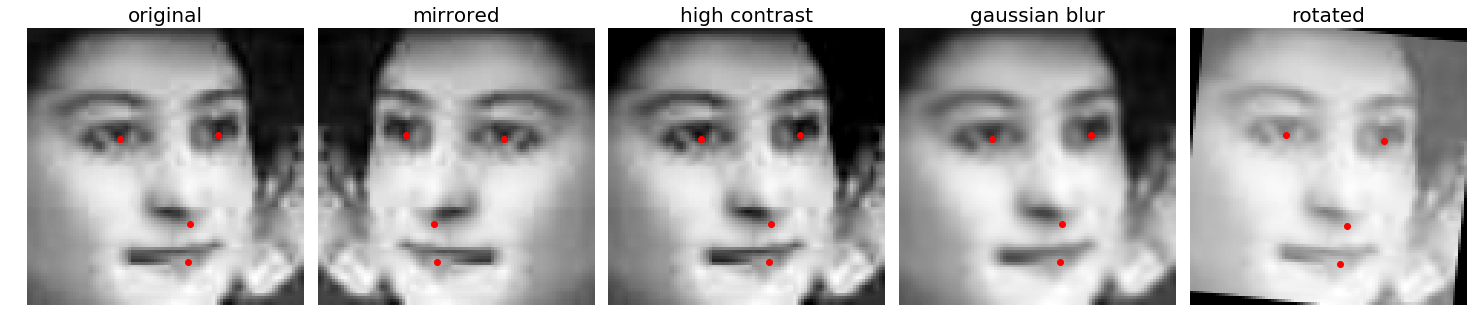

In [25]:
imgs = [img1, img2, img3, img4, img5]
labs = [lab1, lab2, lab3, lab4, lab5]
titles = ['original','mirrored','high contrast','gaussian blur','rotated']

fig, axes = plt.subplots(1,5,figsize=(20,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(5):
    ax = axes[i]
    ax.imshow(imgs[i], cmap='gray')
    ax.scatter(labs[i][0::2] * 48 + 48, labs[i][1::2] * 48 + 48, c='r')
    ax.axis('off')
    ax.set_title(titles[i], fontsize=20)

In [21]:
# delete all single augmentation sets to preserve memory
del flipped_data, contrast_data, blur_data, rotate_data,flipped_labels, contrast_labels, blur_labels, rotate_labels, flipped_dev_data, contrast_dev_data, blur_dev_data, rotate_dev_data,flipped_dev_labels, contrast_dev_labels, blur_dev_labels, rotate_dev_labels,flipped_data_complete, contrast_data_complete, blur_data_complete, rotate_data_complete,flipped_labels_complete, contrast_labels_complete, blur_labels_complete, rotate_labels_complete,contrast_dev_data_complete, blur_dev_data_complete, rotate_dev_data_complete,flipped_dev_labels_complete, contrast_dev_labels_complete, blur_dev_labels_complete, rotate_dev_labels_complete

# Establish Baseline

## Simple Models

### Guess the average value

Not sure whether or not we are keeping guess-the-average or not

In [27]:
# ALEX: The guess-the-average baseline was breaking so I modifed it here
# and moved the original to the appendix. If we want to keep this we 
# probably want to do somethign smarter with the NA's rather than just 
# drop them

# # with missing values
# avg_position = np.nanmean(train_labels, axis=0)
# idx = ~np.any(np.isnan(dev_labels), axis=1)
# dev = dev_labels[idx]
# predictions = np.ones(dev.shape) * avg_position
# mse = np.sqrt(mean_squared_error(dev, predictions)) * 48

# no missing values
avg_position = np.mean(train_labels_aug_comp, axis=0)
predictions = np.ones(dev_labels_aug_comp.shape) * avg_position
mse = np.sqrt(mean_squared_error(dev_labels_aug_comp, predictions)) * 48
mse

3.3649069535054457

In [ ]:
# More simple baselines
regressors = {
    'DecisionTree': DecisionTreeRegressor(), # Maddie
    'NearestNeighbors': KNeighborsRegressor(), # Tennison
#     'NaiveBayes': MultinomialNB(), # Mark
#     'LogisticRegression': LogisticRegression() # Alex
} 

def model_training(model, train_data, labels, dev_data, dev_labels):
    
    # Convert arrays of arrays to a numpy matrix or sklearn .fit doesn't like them.
#     X = np.empty((train_data.shape[0], train_data.iloc[0].shape[0]))
#     for row in range(train_data.shape[0]):
#         X[row,:] = train_data.iloc[row]
#     Z = np.empty((dev_data.shape[0], dev_data.iloc[0].shape[0]))
#     for row in range(dev_data.shape[0]):
#         Z[row,:] = dev_data.iloc[row]

    X = train_data.reshape(-1, 96**2)
    Y = labels
    Z = dev_data.reshape(-1, 96**2)
        
    model.fit(X,Y)
    predictions = model.predict(Z)
    
    mse = np.sqrt(mean_squared_error(dev_labels, predictions)) * 48
    
    return mse

for k,v in regressors.items():
    print(k,':',model_training(
        v, train_data_comp, train_labels_comp,
        dev_data_comp, dev_labels_comp        
    ))

DecisionTree : 3.68692315215369


### Decision Tree - Maddie

In [ ]:
# placeholder

### KNN - Tennison

**Rational:** We pick kNN because all facial features are on the same location on the face i.e left eye is on the upper left, right eye is on the upper right, nose is in the middle, etc. Given a set of images, kNN should be able to figure out which pixels is generally associated with the eye area, the nose area, etc.

**Weakness:** One potential weakness of this algorithm may be images where the head is tilted or located off center. For example, if an image has a face translated to the right, then it may mistake the left eye on the image for a right eye

# Convolutional Neural Network

## Building the CNN
The default values I have defined do not need to stay here they can be whatever and will probably change once we run a proper grid search

Placeholder for explanation of parameter choices

**Build a custom loss function to handle NA values**

In [ ]:
# building a time callback to track total runtime
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
# building a custom loss function to handle NAs
def mean_squared_error_with_missing(y_true, y_pred):
    
    # figure out which labels are present
    present = tf.logical_not(tf.is_nan(y_true))
    
    # select only those labels
    present_labels_true = tf.boolean_mask(y_true, present)
    present_labels_pred = tf.boolean_mask(y_pred, present)
    
    # compute mean squared error
    loss = tf.math.reduce_mean(tf.math.squared_difference(present_labels_true,present_labels_pred))
    
    return loss

**Build the model**

How we built the model:  
We had to decide on the default hyperparameters for our CNN model 

In [ ]:
def build_CNN(
    num_ConvLayers=3, 
    num_DenseLayers=2,
    filters=[32,64,128],
    kernels=[(3,3),(3,3),(3,3)], 
    pools=[(2,2),(2,2),(2,2)], 
    dense_nodes=[1000,1000], 
    optimizer='Adam', 
    dropout=None,
    input_shape=(96,96,1),
    loss=mean_squared_error_with_missing
):
    '''This function builds a CNN model
    num_ConvLayers --> is the number of convolutional layer groups where 
    each group contains a convolutional layer, a pooling layer, and an
    optional dropout layer
    
    num_DenseLayers --> is the number of dense layers after flattening
    the convolutional output
    
    filters --> a list of the number of filters used in each
    convolutional layer specified in num_ConvLayers
    
    kernels --> a list of the kernel size to use in each convolutional
    layer specified in num_ConvLayers
    
    pools --> a list of the kernel size to use in each pooling layer
    specified in num_ConvLayers
    
    dense_nodes --> a list of the number of units in each dense layer
    specified in num_DenseLayers
    
    dropout --> optional, a list of the dropout rates at each 
    convolutional layer
    
    input_shape --> the shape of the input data
    '''
    # define a Sequential model
    model = Sequential()
    
    # add convolutional layer groups
    for i in range(num_ConvLayers):
        model.add(Conv2D(
            filters=filters[i],
            kernel_size=kernels[i],
            strides=(1,1),
            padding='same',
            activation='relu',
            input_shape=input_shape
        ))
        model.add(MaxPooling2D(
            pool_size=pools[i],
            strides=None
        ))
        
        # add dropout layers if specified
        if dropout:
            model.add(Dropout(rate=dropout[i]))
    
    # flatten the convolutional layers
    model.add(Flatten())
    
    # add the dense layers
    for j in range(num_DenseLayers):
        model.add(Dense(
            units=dense_nodes[j],
            activation='relu'
        ))
        
    # create the output layer
    model.add(Dense(units=30))
    
    # compile the model
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

**Train the model**

In [ ]:
def train_model(
    model, 
    train_data, train_labels, 
    dev_data=None, dev_labels=None,
    batch_size=32,
    verbose=1,
    epochs=10
):
    time_callback = TimeHistory()
    hist = keras.callbacks.History()
    if not dev_data is None:
        model.fit(
            train_data, train_labels, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_data=(dev_data, dev_labels),
            verbose=verbose,
            callbacks=[hist, time_callback]
        )
    else:
        model.fit(
            train_data, train_labels, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_split=0.2,
            verbose=verbose,
            callbacks=[hist, time_callback]
        )
    print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
    print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))
    
    return hist, time_callback

**Visualize the model**

In [ ]:
def plot_NN(model):
    plot_model(model, to_file='model.png', show_shapes=True)
    mod = plt.imread('model.png')
    fig = plt.figure(figsize=(10,20), frameon=False)
    plt.imshow(mod)
    plt.axis('off')

###  Running CNN
I think we discussed building a CNN with a set of default parameters, train it on the original data set, then augment the data and train it again, then change some parameters in the model and train it again, etc

<table> 
<tr>
<th> Model Name </th> <th> Model Parameters </th> <th> Training Criteria </th>
</tr>
<tr>
<td> Model 1a </td> <td> Default </td> <td> 10 epochs, 100 data points </td>
</tr>
    <tr>
<td> Model 1b </td> <td> Default </td> <td> 10 epochs, Original data </td>
</tr>
    <tr>
<td> Model 1c </td> <td> Default </td> <td> 10 epochs, Augmented data </td>
</tr>
    <tr>
<td> Model 2a </td> <td> ... </td> <td> ... </td>
</tr>
</table>

#### Model 1

In [ ]:
model1 = build_CNN()

In [ ]:
plot_NN(model1)

In [ ]:
hist1, runtime1 = train_model(
    model1, train_data_complete, train_labels, dev_data, dev_labels
)

We could try running this for longer, but the way the validation loss levels off even as the training loss continues to shrink shows that the model is overfitting. This is unsurprising given the small size of our data set, and the large number of parameters. For better results, we should next try the full (unaugmented) data set and see how it fares.

#### Model 2

In [ ]:
model2 = build_CNN()

In [ ]:
hist2, runtime2 = train_model(
    model1b, train_data_set, train_labels_set, 
    dev_data_set, dev_labels_set
)

This did significantly better and the validation loss was still improving alongside the training loss at the end of ten epochs. Given this continued improvement, it would be worth running this for longer.

### Predict missing values
A large percentage of the points are missing, meaning we are not using a large percentage of the information we have in the dataset. However facial keypoints will, in general, follow location patterns across images of faces. Uing a simple two layer neural net we use the moset commonly labeled key points to predict values for the features that are not labeled in a majority of the data. Then we can fill the missing labels in with these predicted points and retrain the data with no missing values

### 2-layer Neural Net

#### Not sure we need this cell since we will have data set without missing values from the simple models above

In [ ]:
for i,label in enumerate(feature_dict.keys()):
    print(i, ' ', label, ' ', np.sum(np.logical_not(np.isnan(train_labels[:,i]))))
    
is_data_complete = np.logical_not(np.any(np.isnan(train_labels),axis = 1))
train_data_complete = train_data[is_data_complete]
train_labels_complete = train_labels[is_data_complete]
# len(train_data_complete)

# train_data_complete.shape, train_labels_complete[:,[0,1,2,3,20,21,28,29]].shape

### Build the 2-layer NN

In [ ]:
basicNN = Sequential()
basicNN.add(Dense(units=1000,activation='relu'))
basicNN.add(Dense(units=1000,activation='relu'))
basicNN.add(Dense(units=1000,activation='relu'))

# create the output layer
basicNN.add(Dense(units=30))

# compile the model
# basicNN.compile(loss='mean_squared_error', optimizer='Adam')
basicNN.compile(loss=mean_squared_error_with_missing, optimizer='Adam')

In [ ]:
time_callback = TimeHistory()
hist = keras.callbacks.History()
basicNN.fit(
    x=train_labels_complete_set[:,[0,1,2,3,20,21,28,29]], y=train_labels_complete_set,
    batch_size=32,
    epochs=20,
    validation_split=0.2, 
#     validation_data = dev_data
    verbose=0,
    callbacks=[hist, time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

In [ ]:
idx = np.random.randint(0, len(train_data_complete), 16)
data_sample = train_data_complete[idx, :, :, :]

pred = basicNN.predict(train_labels_complete[:,[0,1,2,3,20,21,28,29]])

label_sample = pred[idx, :]
label_sample_true = train_labels_complete[idx, :]

plot_sample(data_sample, label_sample_true, labels2=label_sample)

In [ ]:
idx = np.random.randint(0, len(train_data_set), 16)
data_sample = train_data_set[idx, :, :, :]

pred = basicNN.predict(train_labels_set[:,[0,1,2,3,20,21,28,29]])

label_sample = pred[idx, :]
label_sample_true = train_labels_set[idx, :]

plot_sample(data_sample, label_sample_true, labels2=label_sample)

#### Model 3

In [ ]:
# augment some data or change a parameter
model2 = build_CNN()
plot_NN(model2)

In [ ]:
hist2, runtime2 = train_model(model2, train_data_set, train_labels_set, dev_data_set)

#### Visualize training improvement
Doesn't look like an improvement, but it will once we train on the whole data sets

In [ ]:
val_rms1 = np.sqrt(hist1c.history['val_loss']) * 48
train_rms1 = np.sqrt(hist1c.history['loss']) * 48
val_rms1b = np.sqrt(hist2.history['val_loss']) * 48
train_rms1b = np.sqrt(hist2.history['loss']) * 48

plt.plot(val_rms1, 'g-')
plt.plot(train_rms1, 'b-')
plt.plot(val_rms2, 'g--')
plt.plot(train_rms2, 'b--')
plt.legend([
    'val loss - model 1','training loss - model 1',
    'val loss - model 2','training loss - model 2'
])

# Predict on Test Data

Repeat these steps for each final model

In [ ]:
pred = model.predict(test_data)
pred[0]

In [ ]:
idx = np.random.randint(0, len(test_data), 16)
test_sample = test_data[idx, :, :, :]
pred_sample = pred[idx, :]

In [ ]:
plot_sample(test_sample, pred_sample)

## Kaggle Output

In [ ]:
#Predict values for your chosen model
pred = model1b.predict(test_data)

In [ ]:
# Get the list of required test points
lookup = pd.read_csv('IdLookupTable.csv')

In [ ]:
#Match up the test points with the predicted values

labelNums = {}
for index, label in enumerate(train.columns.values):
    labelNums[label] = index
    
lookup['FeatureNum'] = lookup.apply(lambda row: labelNums[row['FeatureName']], axis=1)
lookup.Location =  np.minimum(96,np.maximum(0,pred[lookup.ImageId-1,lookup.FeatureNum]*48 + 48))

In [ ]:
# save the rowid and the associated location to a csv

lookup.to_csv(path_or_buf='kagglesubmission.csv',columns=['RowId','Location'],index=False)

To submit, run:
kaggle competitions submit -c facial-keypoints-detection -f submission.csv -m "Message"

# Conclusion

Put a conclusion here comparing and contrasting the models and how well we did on Kaggle

## Summary Table

# Appendix

### Daniel Nouri model transferred to Keras (as best as I could)

In [ ]:
# making a callback so I can compare runtimes
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
model = Sequential()

# first group of layers
model.add(Conv2D(
    32, 
    kernel_size=(3,3), 
    activation='relu',
    input_shape=(96, 96, 1), 
#     data_format='channels_first'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second group of layers
model.add(Conv2D(
    64, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third group of layers
model.add(Conv2D(
    128, 
    kernel_size=(2, 2), 
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(30))

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [ ]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4,
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('RMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

### Alex trying to understand...

In [ ]:
model = Sequential()

# FIRST CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=32, # don't yet fully understand how to choose this dimension
    kernel_size=(3,3),
    strides=(1,1),
    padding='same',
    activation='relu',
    input_shape=(96, 96, 1),
))
# input_shape = (batch, rows, cols, channels) --> (batch, 96, 96, 1)
# padding = 'same' so for a kernel of size (3,3) and strides=(1,1) this 
# will pad two rows and two columns of zeros on the edges so that the 
# output shape gives an tensor with 96 rows and 96 columns
# output_shape = (batch, new_rows, new_cols, filters) --> (batch, 96, 96, 32)

# POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None
))
# setting strides=None sets the strides to a default of pool_size, so 
# here we are really setting strides=(2,2) which is what we want so we 
# don't miss any pixels and we don't count any pixels more than once
# the strides is essentially the factor by which to downscale the output
# so setting the strides=(2,2) will have the dimensions of input
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 48, 48, 32)


# SECOND CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=64, # don't know why we increased this number by 2
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 48, 48, 32)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 48, 48, 64)

# SECOND POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2), 
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 48, 48, 64)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 24, 24, 64)

# THIRD CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=128, # don't know how to choose this value
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 24, 24, 64)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 24, 24, 128)

# THIRD POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 24, 24, 128)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 12, 12, 128)

# FLATTEN THE POOLED OUTPUT TO CLASSIFY
model.add(Flatten())
# flatten the output into a single layer of 
#     shape = [batch, pool_rows * pool_cols * in_filters]
#         --> [batch, 12 * 12 * 128] = [batch, 18432]

# ADD ONE FULLY CONNECTED LAYER TO PROCESS THE FLATTENED DATA
model.add(Dense(
#     500,
    1000,
    activation='relu'
))
# input_shape = [batch, flattened_nodes] = [batch, 18432]
# output_shape = [batch, out_nodes] = [batch, 500]

# FINAL OUTPUT LAYER
model.add(Dense(30))
# input_shape = [batch, in_nodes] = [batch, 500]
# output_shape = [batch, num_classes] = [batch, 30]

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=Adam)

In [ ]:
time_callback = TimeHistory()
hist = model.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=4, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Changed the kernel size in the second two layers to (3,3), almost doubled the training time, didn't improve the error by a lot

In [ ]:
# move this cell closer to the top, but putting it here now for convenience in referencing for cell below.
i = 0
feature_dict = {}
for label in train.columns[:-1].values:
# for label in features:
    feature_dict[label] = i
    i += 1
print(feature_dict)

In [ ]:
# Naive baseline - calculate the average (X, Y) of all the labels and 
# guess that every time
n_rows = train_data.shape[0]
n_cols = train_data.iloc[0].shape[0]

for col in [1]: #range(n_cols):
    sum = 0
    for row in range(n_rows):
        sum += train_labels.iloc[row][col]
    avg = sum / n_rows
    predictions = np.ones(dev_data.shape[0]) * avg

    mse = mean_squared_error(dev_labels['left_eye_center_x'], predictions)
    print(mse)

## Grid Search

In [ ]:
# Define the model as a KerasRegressor class

model = KerasRegressor(build_fn=build_CNN, epochs=10)

# Define parameter ranges over which to search

f = list(range(8,72,8))
filts = [[i, i*2, i*4] for i in f]
filts, len(filts)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

k1 = [[(i,i)]*3 for i in range(2,5)]
k2 = [
    [(4,4), (3,3), (2,2)], 
    [(3,3), (2,2), (2,2)], 
    [(2,2), (3,3), (4,4)],
    [(2,2), (2,2), (3,3)],
    [(3,3), (3,3), (2,2)],
    [(2,2), (3,3), (3,3)],
]
k = k1 + k2
k, len(k)

# param_grid = dict(optimizer=optimizer, filters=filts, kernels=k)
# param_grid = dict(optimizer=optimizer, kernels=k)
param_grid = dict(kernels=k)
param_grid

# Run the grid search

grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
#     n_jobs=-1,
    scoring='neg_mean_squared_error',
)

grid_data, grid_labels = shuffle(train_data_set, train_labels_set, random_state=666)
grid_data, grid_labels = grid_data[:100], grid_labels[:100]
grid_data.shape, grid_labels.shape

grid_result = grid.fit(grid_data, grid_labels, verbose=1)

# Get the results and store to csv

cv_results = pd.DataFrame(grid_result.cv_results_)
cv_results.head()
cv_results.to_csv('grid_search_results2.csv')
grid_result.best_params_

## Lighten/Darken Images

In [ ]:
# From here: https://en.wikipedia.org/wiki/Normalization_(image_processing)
def normalize_image(data, min = 0, max = 255):

    new_dataset = []
    split_data = np.split(data, data.shape[0])
    
    for image in split_data:
        image = np.squeeze(image)
        
        image = image * 255
        
        old_min, old_max, old_avg = np.amin(image), np.amax(image), np.mean(image)        
        new_min, new_max, new_avg = min, max, max-min/2
        
        mfactor = old_avg/new_avg

        new_image = []
        
        for pixel in image.flatten():
            #new_pixel = int((pixel-old_min)*((new_max-new_min)/(old_max-old_min))+ new_min)
            new_pixel = pixel * mfactor
            new_image.append(new_pixel)
        
        new_image = np.array(new_image)/ 255
        new_image = new_image.reshape(96, 96, 1)
        
        new_dataset.append(new_image)
    
    return np.stack(new_dataset, axis=0 )

train_data_normalized = normalize_image(train_data)
test_data_normalized = normalize_image(test_data)

f, axarr = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

print (train_data[1].flatten())
print (train_data_normalized[1].flatten())

axarr[0].imshow(train_data[1].reshape(96,96), cmap='gray')
axarr[1].imshow(train_data_normalized[1].reshape(96,96), cmap='gray')

In [ ]:
# Test for augmentation

image = np.squeeze(crop_data[2])

print (image.shape)

plt.figure()
plt.imshow(image, cmap='gray')

#for c in range(0, crop_labels.shape[1], 2):
#    x = crop_labels[111][c]* 48 + 48
#    y = crop_labels[111][c+1]* 48 + 48
        
#    plt.scatter(x,y,cmap='pastel1')